In [2]:
import matplotlib.pyplot as ply
%matplotlib inline

import networkx as nx
import numpy as np

from qiskit_aqua.translators.ising import maxcut
from qiskit_aqua.input import get_input_instance
from qiskit_aqua import run_algorithm
from qiskit_qcgpu_provider import QCGPUProvider

In [3]:
nodes = 5
edges = [
    # Tuple (i, j, weight), 
    # where (i, j) is an edge.
    (0, 1, 1.0),
    (0, 2, 1.0),
    (1, 2, 1.0),
    (1, 4, 1.0),
    (3, 4, 1.0),
    (2, 3, 1.0)
]

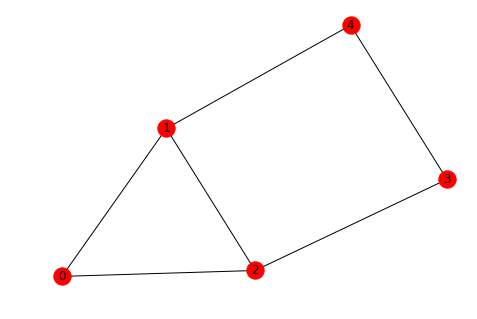

In [4]:
G = nx.Graph()
G.add_nodes_from(np.arange(0, nodes, 1))
G.add_weighted_edges_from(edges)
nx.draw(G, with_labels=True)

In [5]:
# Computing the weight matrix
weights = np.zeros([nodes, nodes])
for i in range(nodes):
    for j in range(nodes):
        edge_data = G.get_edge_data(i, j, default = None)
        # check if there is no edge
        if edge_data != None:
            weights[i, j] = edge_data['weight']
weights

array([[0., 1., 1., 0., 0.],
       [1., 0., 1., 0., 1.],
       [1., 1., 0., 1., 0.],
       [0., 0., 1., 0., 1.],
       [0., 1., 0., 1., 0.]])

In [6]:
# Calculate the max cut
best = 0
for b in range(2**nodes):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(nodes)))]
    cost = 0
    for i in range(nodes):
        for j in range(nodes):
            cost = cost + weights[i,j]*x[i]*(1-x[j])
    if best < cost:
        best = cost
        xbest_brute = x 
    # print('case = ' + str(x)+ ' cost = ' + str(cost))
    
print('Optimal Solution: case = ' + str(xbest_brute) + ', cost = ' + str(best))

Optimal Solution: case = [0, 1, 0, 1, 0], cost = 5.0


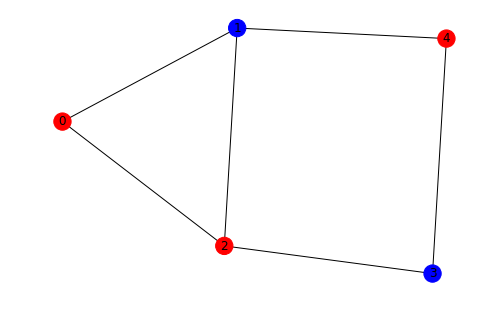

In [7]:
# Plot the optimal solution
colors = ['r' if xbest_brute[i] == 0 else 'b' for i in range(nodes)]
nx.draw(G, node_color=colors, with_labels=True)

## Solving Using The Variational Quantum Eigensolver

In [8]:
operator, offset = maxcut.get_maxcut_qubitops(weights)
algorithm_input = get_input_instance('EnergyInput')
algorithm_input.qubit_op = operator

algorithm_parameters = {
    'problem': { 'name': 'ising', 'random_seed': 3242 },
    'algorithm': { 'name': 'VQE', 'operator_mode': 'matrix' },
    'optimizer': { 'name': 'SPSA', 'max_trials': 300 },
    'variational_form': {'name': 'RY', 'depth': 5, 'entanglement': 'linear'}
}

In [13]:
backend = QCGPUProvider().get_backend('statevector_simulator')
result = run_algorithm(algorithm_parameters, algorithm_input, backend=backend)

In [14]:
x = maxcut.sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('maxcut objective:', result['energy'] + offset)
print('solution:', maxcut.get_graph_solution(x))
print('solution objective:', maxcut.maxcut_value(x, weights))

energy: -1.9879268278335847
maxcut objective: -4.987926827833585
solution: [0. 0. 1. 0. 1.]
solution objective: 5.0


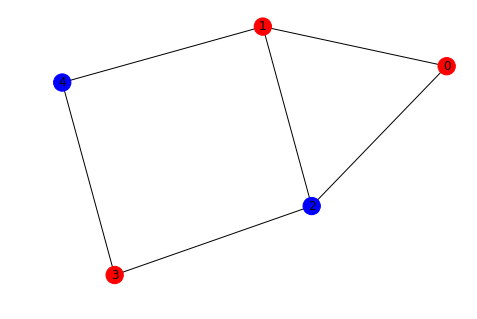

In [22]:
colors = ['r' if maxcut.get_graph_solution(x)[i] == 0 else 'b' for i in range(nodes)]
nx.draw(G, node_color=colors, with_labels=True)

In [20]:
import warnings
warnings.filterwarnings('ignore')